<a href="https://colab.research.google.com/github/Mickhelgoh/BrainTumor/blob/main/2Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install  -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mickhel","key":"d56d36a095e432814b8192ac423f74ef"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d 'sartajbhuvaji/brain-tumor-classification-mri'

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
100% 86.8M/86.8M [00:00<00:00, 115MB/s]
100% 86.8M/86.8M [00:00<00:00, 93.1MB/s]


In [5]:
import zipfile,os,shutil

In [6]:
filezip = '/content/brain-tumor-classification-mri.zip'
extraczip = zipfile.ZipFile(filezip,'r')
extraczip.extractall('dataset')

In [7]:
os.listdir("/content/dataset")

['Training', 'Testing']

In [8]:
for dirname, _, filenames in os.walk('/content/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/dataset/Training/glioma_tumor/gg (501).jpg
/content/dataset/Training/glioma_tumor/gg (801).jpg
/content/dataset/Training/glioma_tumor/gg (728).jpg
/content/dataset/Training/glioma_tumor/gg (735).jpg
/content/dataset/Training/glioma_tumor/gg (753).jpg
/content/dataset/Training/glioma_tumor/gg (170).jpg
/content/dataset/Training/glioma_tumor/gg (711).jpg
/content/dataset/Training/glioma_tumor/gg (575).jpg
/content/dataset/Training/glioma_tumor/gg (48).jpg
/content/dataset/Training/glioma_tumor/gg (671).jpg
/content/dataset/Training/glioma_tumor/gg (686).jpg
/content/dataset/Training/glioma_tumor/gg (264).jpg
/content/dataset/Training/glioma_tumor/gg (496).jpg
/content/dataset/Training/glioma_tumor/gg (677).jpg
/content/dataset/Training/glioma_tumor/gg (36).jpg
/content/dataset/Training/glioma_tumor/gg (141).jpg
/content/dataset/Training/glioma_tumor/gg (541).jpg
/content/dataset/Training/glioma_tumor/gg (421).jpg
/content/dataset/Training/glioma_tumor/gg (808).jpg
/content/datas

100%|██████████| 74/74 [00:00<00:00, 368.06it/s]


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.5038 - loss: 14.1897
Epoch 1: val_accuracy improved from -inf to 0.62997, saving model to model6_best.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 126s 699ms/step - accuracy: 0.5048 - loss: 14.1577 - val_accuracy: 0.6300 - val_loss: 11.0312 - learning_rate: 0.0010
Epoch 2/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7731 - loss: 6.5745
Epoch 2: val_accuracy improved from 0.62997 to 0.84709, saving model to model6_best.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.7734 - loss: 6.5678 - val_accuracy: 0.8471 - val_loss: 5.1530 - learning_rate: 0.0010
Epoch 3/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8578 - loss: 4.5873
Epoch 3: val_accuracy improved from 0.84709 to 0.90520, saving model to model6_best.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.8578 - loss: 4.5843 - val_acc

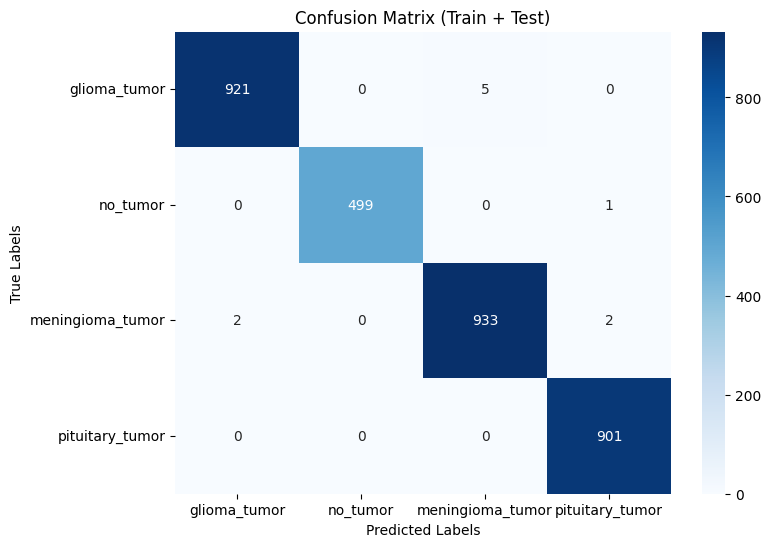

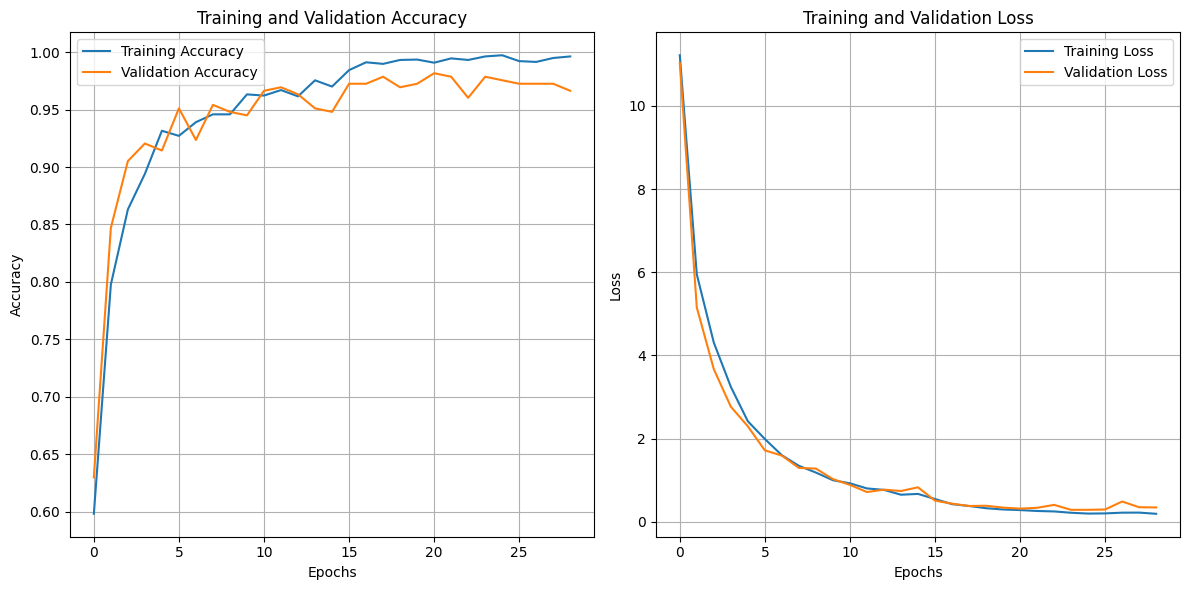

In [9]:
# Import libraries
from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset paths
TRAIN_PATH = '/content/dataset/Training'
TEST_PATH = '/content/dataset/Testing'
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
X = []
y = []
image_size = 150

# Load the dataset
for label in labels:
    folder_path = os.path.join(TRAIN_PATH, label)
    for img_file in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, img_file))
        img = cv2.resize(img, (image_size, image_size))
        X.append(img)
        y.append(label)

for label in labels:
    folder_path = os.path.join(TEST_PATH, label)
    for img_file in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, img_file))
        img = cv2.resize(img, (image_size, image_size))
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

# Convert labels to integers
y = np.array([labels.index(label) for label in y])
y = tf.keras.utils.to_categorical(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    shear_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Load DenseNet121 and VGG16 base models without top layers
efficientNetB0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Fine-tune some layers of both models (Gradual Unfreezing)
for layer in efficientNetB0.layers[:100]:
    layer.trainable = False
for layer in vgg16.layers[:100]:
    layer.trainable = False

# Extract features from both models
efficientNetB0_out = GlobalAveragePooling2D()(efficientNetB0.output)
efficientNetB0_out = Dropout(rate=0.5)(efficientNetB0_out)  # Increase dropout

vgg_out = GlobalAveragePooling2D()(vgg16.output)
vgg_out = Dropout(rate=0.5)(vgg_out)  # Increase dropout

# Concatenate the outputs of both models
concatenated = Concatenate()([efficientNetB0_out, vgg_out])

# Add Dense layers after concatenation with regularization, batch normalization, and dropout
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.01))(concatenated)  # Increased L2 regularization
x = Dropout(0.5)(x)  # Increased dropout
x = BatchNormalization()(x)

x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)  # Increased L2 regularization
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout

# Output layer with softmax activation (4 classes)
output_layer = Dense(4, activation="softmax")(x)

# Create the final model
model6 = Model(inputs=[efficientNetB0.input, vgg16.input], outputs=output_layer)
# Compile the model with SGD optimizer
model6.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("model6_best.keras", monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model using the datagen.flow method
history6 = model6.fit(
    x=[X_train, X_train],
    y=y_train,
    validation_data=([X_test, X_test], y_test),
    epochs=40,
    batch_size=32,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

# Get predictions for both training and testing sets (combined for classification report and confusion matrix)
train_predictions = model6.predict([X_train, X_train])
train_predictions = np.argmax(train_predictions, axis=-1)

train_true_labels = np.argmax(y_train, axis=-1)

test_predictions = model6.predict([X_test, X_test])
test_predictions = np.argmax(test_predictions, axis=-1)

test_true_labels = np.argmax(y_test, axis=-1)
# Combine both the predictions and true labels of training and testing data
combined_predictions = np.concatenate([train_predictions, test_predictions])
combined_true_labels = np.concatenate([train_true_labels, test_true_labels])

# Classification report for the combined data (train + test)
print("Classification Report (Train + Test):")
print(classification_report(combined_true_labels, combined_predictions, target_names=labels))

# Confusion matrix for the combined data (train + test)
cm_combined = confusion_matrix(combined_true_labels, combined_predictions)

# Plot confusion matrix for the combined data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Train + Test)')
plt.show()

# Plot training and validation accuracy and loss together
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()